# 1. Import library

In [1]:
!pip install --no-index --no-deps /kaggle/input/pytorch/einops-0.8.0-py3-none-any.whl

Processing /kaggle/input/pytorch/einops-0.8.0-py3-none-any.whl


In [2]:
!pip install --no-index --no-deps /kaggle/input/pytorchtransformer/tab_transformer_pytorch-0.3.0-py3-none-any.whl

Processing /kaggle/input/pytorchtransformer/tab_transformer_pytorch-0.3.0-py3-none-any.whl


In [3]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
import polars as pl
import polars.selectors as cs
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [4]:
from tab_transformer_pytorch import FTTransformer
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [5]:
SEED = 42
n_splits = 5

# 2. Load data

In [6]:
train  = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test   = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')
data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')
print("Train data shape: ", train.shape)
print("Test data shape: ", test.shape)

Train data shape:  (3960, 82)
Test data shape:  (20, 59)


In [7]:
train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,NaN,71.0,70.0,104.0,NaN,NaN,NaN,NaN,Fall,16.0,0.0,18.0,1.0,19.9,2.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,Fall,3.0,4.52277,16.3642,1206.880,2051.70,19.46110,70.8117,14.0629,2.30138,11.58830,1.0,33.3709,17.97970,66.2889,29.7790,52.8320,NaN,NaN,Winter,3.260,Winter,3.0,3.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,32.

In [8]:
data_dict

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
...,...,...,...,...,...,...
76,Sleep Disturbance Scale,SDS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
77,Sleep Disturbance Scale,SDS-SDS_Total_Raw,Total Raw Score,int,NaN,NaN
78,Sleep Disturbance Scale,SDS-SDS_Total_T,Total T-Score,int,NaN,NaN
79,Internet Use,PreInt_EduHx-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


# 3. Train data Analysis

Let's first see the features that do not exist in test set

In [9]:
train_cols = set(train.columns)
test_cols = set(test.columns)
columns_not_in_test = sorted(list(train_cols - test_cols))
data_dict[data_dict['Field'].isin(columns_not_in_test)]

,Instrument,Field,Description,Type,Values,Value Labels
54,Parent-Child Internet Addiction Test,PCIAT-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
55,Parent-Child Internet Addiction Test,PCIAT-PCIAT_01,How often does your child disobey time limits ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,Parent-Child Internet Addiction Test,PCIAT-PCIAT_02,How often does your child neglect household ch...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,Parent-Child Internet Addiction Test,PCIAT-PCIAT_03,How often does your child prefer to spend time...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,Parent-Child Internet Addiction Test,PCIAT-PCIAT_04,How often does your child form new relationshi...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,Parent-Child Internet Addiction Test,PCIAT-PCIAT_05,How often do you complain about the amount of ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,Parent-Child Internet Addiction Test,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,Parent-Child Internet Addiction Test,PCIAT-PCIAT_07,How often does your child check his or her e-m...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,Parent-Child Internet Addiction Test,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,Parent-Child Internet Addiction Test,PCIAT-PCIAT_09,How often does your child become defensive or ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


Let's see the minimum and maximum PCIAT Score in Tranining set

In [10]:
pciat_min_max = train.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max'])
pciat_min_max = pciat_min_max.rename(
    columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score'}
)
pciat_min_max

,Minimum PCIAT total Score,Maximum total PCIAT Score
sii,,
0.0,0.0,30.0
1.0,31.0,49.0
2.0,50.0,79.0
3.0,80.0,93.0


We notice that some cells for sii are missing

In [11]:
train_with_sii = train[train['sii'].notna()][columns_not_in_test]
train_with_sii[train_with_sii.isna().any(axis=1)].head().style.applymap(
    lambda x: 'background-color: #FFC0CC' if pd.isna(x) else ''
)

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,PCIAT-Season,sii
24,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,Summer,0.000000
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,Fall,0.000000
104,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,Fall,1.000000
141,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,Winter,0.000000
142,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,Spring,0.000000


We also notice some unrealistic value for Physical too

In [12]:
wh_cols = [
    'Physical-BMI', 'Physical-Height',
    'Physical-Weight', 'Physical-Waist_Circumference'
]

(train[wh_cols] == 0).sum()

Physical-BMI                     7
Physical-Height                  0
Physical-Weight                 61
Physical-Waist_Circumference     0
dtype: int64

Some HR/BP are wrong as they are lethal to human

In [13]:
bp_hr_cols = [
    'Physical-Diastolic_BP', 'Physical-Systolic_BP',
    'Physical-HeartRate'
]

(train[bp_hr_cols] < 50).sum()

Physical-Diastolic_BP    88
Physical-Systolic_BP      2
Physical-HeartRate       12
dtype: int64

Systolic BP should always larger or equal than Diastolic BP

In [14]:
train[train['Physical-Systolic_BP'] <= train['Physical-Diastolic_BP']][bp_hr_cols]

,Physical-Diastolic_BP,Physical-Systolic_BP,Physical-HeartRate
1140,179.0,139.0,103.0
1879,117.0,114.0,114.0
2386,76.0,76.0,116.0
3199,0.0,0.0,NaN
3344,98.0,73.0,96.0


Now let's see the correlation

Basic_Demos-Age                           0.409559
Physical-BMI                              0.240858
Physical-Height                           0.420765
Physical-Weight                           0.353048
Physical-Waist_Circumference              0.327013
Physical-Systolic_BP                      0.147081
PreInt_EduHx-computerinternet_hoursday    0.374124
SDS-SDS_Total_T                           0.237718
FGC-FGC_CU                                0.287494
FGC-FGC_GSND                              0.146813
FGC-FGC_GSD                               0.160472
FGC-FGC_PU                                0.196006
FGC-FGC_TL                                0.136696
BIA-BIA_BMI                               0.248060
BIA-BIA_FFMI                              0.109694
BIA-BIA_Frame_num                         0.193631
Name: PCIAT-PCIAT_Total, dtype: float64


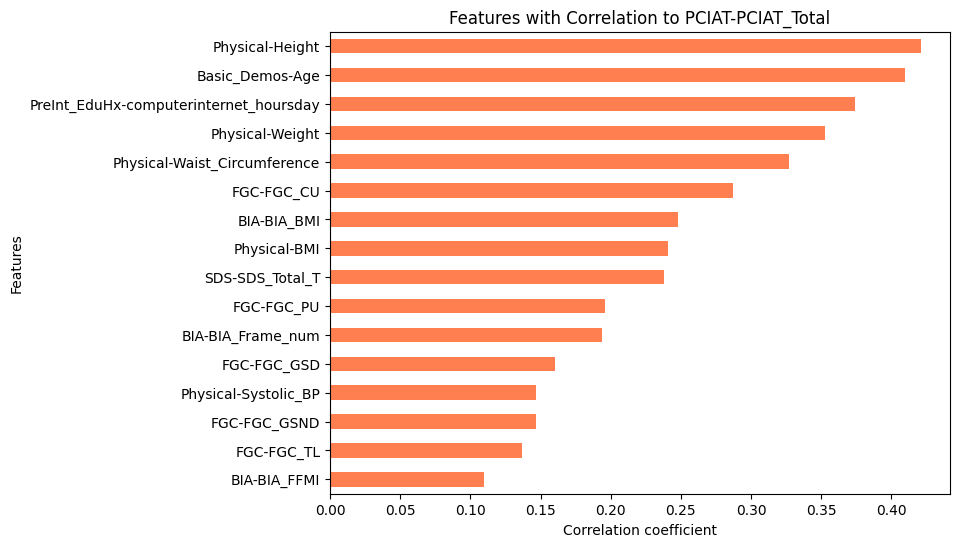

In [15]:
columns_to_analyze = [
    'PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI',
    'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
    'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Physical-HeartRate',
    'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'PAQ_A-PAQ_A_Total',
    'PAQ_C-PAQ_C_Total', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
    'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL',
    'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW',
    'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW',
    'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW'
]

filtered_df = train[columns_to_analyze]

corr_matrix = filtered_df.corr()

sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')

filtered_corr = sii_corr[(sii_corr > 0.1) | (sii_corr < -0.1)]

print(filtered_corr)

plt.figure(figsize=(8, 6))
filtered_corr.sort_values().plot(kind='barh', color='coral')
plt.title('Features with Correlation to PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()

# 4. Actigraphy data Analysis

Let's look at some example

In [16]:
def analyze_actigraphy(id, only_one_week=False, small=False):
    actigraphy = pl.read_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet')
    train = pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    
    day = actigraphy.get_column('relative_date_PCIAT') + actigraphy.get_column('time_of_day') / 86400e9
    sample = train.filter(pl.col('id') == str(id))  # Convert id to string for matching
    age = sample.get_column('Basic_Demos-Age').item()
    sex = ['boy', 'girl'][sample.get_column('Basic_Demos-Sex').item()]
    
    actigraphy = actigraphy.with_columns([
        (pl.col('relative_date_PCIAT').diff() * 86400).alias('diff_seconds'),
        (pl.col('X').pow(2) + pl.col('Y').pow(2) + pl.col('Z').pow(2)).sqrt().alias('norm')
    ])
    
    day_np = day.to_numpy()

    if only_one_week:
        start = np.ceil(day_np.min())
        mask = (start <= day_np) & (day_np <= start + 7)
        mask &= ~actigraphy.get_column('non-wear_flag').to_numpy()
    else:
        mask = np.full(len(day), True)
    
    if small:
        timelines = [
            ('norm', 'forestgreen', 'ENMO'),
            ('light', 'orange', 'Light')
        ]
    else:
        timelines = [
            ('X', 'm', 'X-axis'),
            ('Y', 'm', 'Y-axis'),
            ('Z', 'm', 'Z-axis'),
            ('norm', 'forestgreen', 'ENMO'),
            ('anglez', 'lightblue', 'Angle Z'),
            ('light', 'orange', 'Light'),
            ('non-wear_flag', 'chocolate', 'Non-wear')
        ]
    
    fig, axs = plt.subplots(len(timelines), 1, sharex=True, 
                           figsize=(12, len(timelines) * 1.1 + 0.5))
    
    if len(timelines) == 1:
        axs = [axs]
    
    # Plot the timelines
    for ax, (feature, color, label) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')
        ax.scatter(day_np[mask],
                  actigraphy.get_column(feature).to_numpy()[mask],
                  color=color, label=label, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')
        if feature == 'diff_seconds':
            ax.set_ylim(-0.5, 20.5)
        ax.set_ylabel(label)
    
    axs[-1].set_xlabel('Day')
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    axs[0].set_title(f'ID={id}, {sex}, age={age}')
    plt.show()

We first see a girl of age 6. We can see that:
* The girl wore the accelerometer for 31 days and then took it off
* The girl is in an environment where the illuminance exceeds 2500 lux every day
* The girl moves a lot: she has enmo values above 2 almost every day.

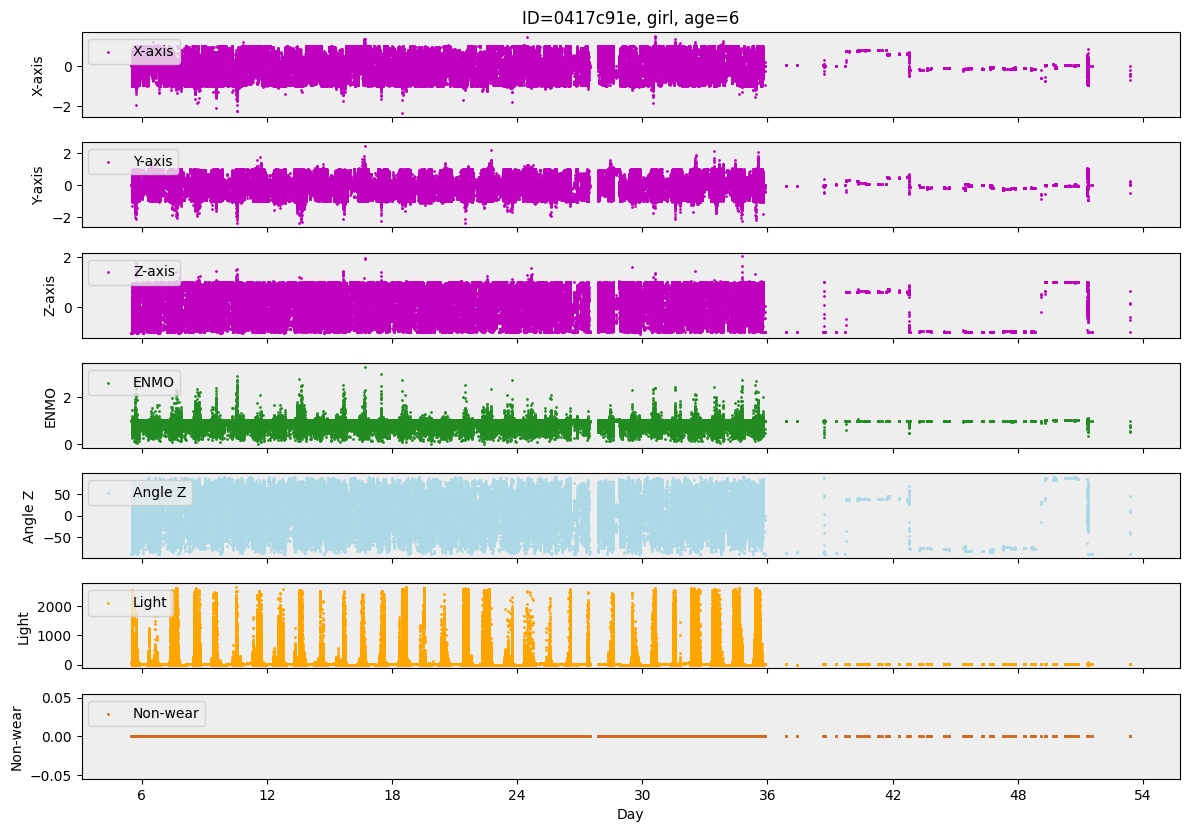

In [17]:
analyze_actigraphy('0417c91e', only_one_week=False)

We next see a boy that have very strange pattern in data. Overall, we will need a lot of data cleaning if we want to use actigraph

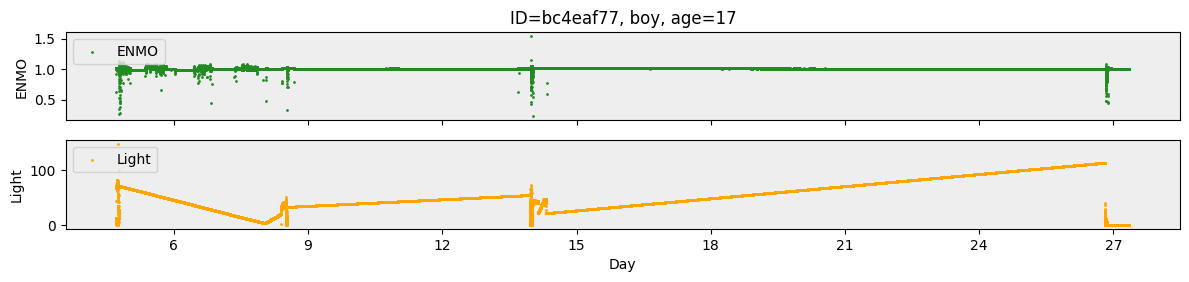

In [18]:
analyze_actigraphy('bc4eaf77', small=True)

# 5. Data Preparation

* **process_file function** : Reads the Parquet file and converts it into DataFrame format. Remove the unnecessary 'step' column and calculate statistical information for the remaining columns.

* **load_time_series function** : Processes all files in the specified directory and extracts statistical information for each file.

In [19]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname):
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

In [20]:
cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']


def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df


def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

# 6. Data Cleaning

In [21]:
wh_cols = [
    'Physical-BMI', 'Physical-Height',
    'Physical-Weight', 'Physical-Waist_Circumference'
]

bp_hr_cols = [
    'Physical-Diastolic_BP', 'Physical-Systolic_BP',
    'Physical-HeartRate'
]

In [22]:
def clean_physical_data(df, wh_cols, bp_hr_cols):
    df[wh_cols] = df[wh_cols].replace(0, np.nan)
    
    df[bp_hr_cols] = df[bp_hr_cols].where(df[bp_hr_cols] >= 50, np.nan)
    
    df.loc[df['Physical-Systolic_BP'] <= df['Physical-Diastolic_BP'], bp_hr_cols] = np.nan
    
    return df

# 7. Auto Encoder

* **AutoEncoder**: used for dimensionality reduction and feature extraction, compressing high-dimensional data into meaningful representation.

In [23]:
# Sparse Autoencoder Model
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, sparsity_weight=1e-5):
        super(SparseAutoencoder, self).__init__()
        self.sparsity_weight = sparsity_weight
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()  # Outputs in the range [0, 1]
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Preparing Data
# Option to use different scalers: MinMaxScaler, StandardScaler, RobustScaler
def prepare_data(data, scaler_type='MinMaxScaler'):
    if scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'RobustScaler':
        scaler = RobustScaler()
    else:
        scaler = MinMaxScaler()
    
    data_scaled = scaler.fit_transform(data)
    return torch.tensor(data_scaled, dtype=torch.float32), scaler

# Apply PCA for Dimensionality Reduction
# This can help focus the autoencoder on the most relevant features
def apply_pca(data, n_components=0.95):
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)
    return data_pca, pca

# Early Stopping Functionality
def early_stopping(patience):
    class EarlyStopping:
        def __init__(self, patience=patience):
            self.patience = patience
            self.counter = 0
            self.best_loss = float('inf')
            self.early_stop = False
        
        def __call__(self, loss):
            if loss < self.best_loss:
                self.best_loss = loss
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
    return EarlyStopping()

# Training the Sparse Autoencoder with DataFrame Output
def perform_autoencoder(data, epochs=100, batch_size=32, learning_rate=0.001, patience=10, scaler_type='MinMaxScaler', use_pca=False, sparsity_weight=1e-5):
    # Preprocess Data
    if use_pca:
        data, pca = apply_pca(data)

    data_tensor, scaler = prepare_data(data, scaler_type=scaler_type)
    train_data, val_data = train_test_split(data_tensor, test_size=0.2, random_state=42)

    train_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_data), batch_size=batch_size, shuffle=False)

    model = SparseAutoencoder(input_dim=data.shape[1], sparsity_weight=sparsity_weight)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.SmoothL1Loss()  # Changed to Smooth L1 Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    stopper = early_stopping(patience=patience)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            encoded, outputs = model(batch)
            
            # Reconstruction loss
            loss = criterion(outputs, batch)
            
            # Sparsity penalty (L1 regularization on encoded activations)
            l1_penalty = torch.mean(torch.abs(encoded))
            loss += sparsity_weight * l1_penalty
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch[0].to(device)
                _, outputs = model(batch)
                loss = criterion(outputs, batch)
                val_loss += loss.item() * batch.size(0)

        val_loss /= len(val_loader.dataset)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Early stopping
        stopper(val_loss)
        if stopper.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Convert tensor back to DataFrame for consistency
    _, data_decoded = model(data_tensor.to(device))
    data_decoded = data_decoded.cpu().detach().numpy()
    df_encoded = pd.DataFrame(data_decoded, columns=[f'feature_{i}' for i in range(data_decoded.shape[1])])
    return df_encoded

# 8. Evaluation

* **Quadratic Weighted Kappa**: This metric is used to evaluate the agreement between two ratings.

* **Threshold Rounder** : This function takes continuous predictions and rounds them to discrete SII ratings (0, 1, 2, or 3) based on predefined thresholds.

* **Evaluate Predictions** : Returns the negative value of the kappa score. In optimization, it is common to maximize positive values ​​while minimizing negative values.



In [24]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [25]:
def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission

# 9. FTTransformer

FTTransformer is an improvement over the TabTransformer method, specifically designed to handle tabular data more effectively. It split data into categorical and numeric features seperately, thus enable it to capture contextual information from both categorical and numeric data

In [26]:
class FTTransformerWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, 
                 dim=32, 
                 depth=6, 
                 heads=8, 
                 attn_dropout=0.1, 
                 ff_dropout=0.1,
                 max_epochs=10,
                 patience=10,
                 lr=1e-4, 
                 batch_size=64):
        # Model hyperparameters
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.attn_dropout = attn_dropout
        self.ff_dropout = ff_dropout
        
        # Training parameters
        self.max_epochs = max_epochs
        self.patience = patience
        self.lr = lr
        self.batch_size = batch_size
        
        # Additional setup
        self.imputer = SimpleImputer(strategy='median')
        
        # Device selection
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Model placeholders
        self.model = None
        self._categorical_columns = None
        self._continuous_columns = None

    def _clear_cuda_memory(self):
        """Clear CUDA memory safely"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

    def _prepare_data(self, X, y=None, is_train=True):
        """Prepare data for training or prediction"""
        # Impute missing values
        X_imputed = self.imputer.fit_transform(X) if is_train else self.imputer.transform(X)
        
        # Identify categorical and continuous columns
        all_cols = X.columns.tolist()

        # Categorical columns (update this list with your specific categorical features)
        cat_cols = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
                    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
                    'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']
        
        self._categorical_columns = [col for col in all_cols if col in cat_cols]
        self._continuous_columns = [
            c for c in all_cols 
            if (c not in self._categorical_columns) and (c != 'sii')
        ]
        
        # Convert to tensors
        X_categ = torch.tensor(
            X_imputed[:, [all_cols.index(c) for c in self._categorical_columns]], 
            dtype=torch.long, 
            device=self.device
        )
        X_cont = torch.tensor(
            X_imputed[:, [all_cols.index(c) for c in self._continuous_columns]], 
            dtype=torch.float32, 
            device=self.device
        )
        
        # Process target if provided
        if y is not None:
            y = y.values if hasattr(y, 'values') else y
            y_tensor = torch.tensor(y, dtype=torch.float32, device=self.device)
            return X_categ, X_cont, y_tensor
        
        return X_categ, X_cont

    def fit(self, X, y):
        """Fit the FTTransformer model"""
        # Clear any existing CUDA memory
        self._clear_cuda_memory()
        
        # Split data into train and validation sets
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Prepare data
        X_train_categ, X_train_cont, y_train_t = self._prepare_data(X_train, y_train)
        X_valid_categ, X_valid_cont, y_valid_t = self._prepare_data(X_valid, y_valid)
        
        # Determine categories for categorical features
        categories = [X[col].nunique() for col in self._categorical_columns]
        
        # Initialize model
        self.model = FTTransformer(
            categories=categories,
            num_continuous=len(self._continuous_columns),
            dim=self.dim,
            dim_out=1,
            depth=self.depth,
            heads=self.heads,
            attn_dropout=self.attn_dropout,
            ff_dropout=self.ff_dropout,
        ).to(self.device)
        
        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', patience=10, factor=0.5, min_lr=1e-5
        )
        
        # Prepare DataLoaders
        train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_t)
        valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_t)
        
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=False)
        
        # Training loop
        best_val_loss = float('inf')
        epochs_no_improve = 0
        
        for epoch in range(self.max_epochs):
            # Training phase
            self.model.train()
            train_loss = self._train_epoch(train_loader, criterion, optimizer)
            
            # Validation phase
            self.model.eval()
            val_loss = self._validate(valid_loader, criterion)
            
            # Learning rate scheduling
            scheduler.step(val_loss)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            # Print progress
            print(f"Epoch {epoch+1}/{self.max_epochs}, "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}")
            
            # Periodic memory cleanup
            if epoch % 10 == 0:
                self._clear_cuda_memory()
            
            # Early stopping condition
            if epochs_no_improve >= self.patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        
        # Final memory cleanup
        self._clear_cuda_memory()
        
        return self

    def _train_epoch(self, train_loader, criterion, optimizer):
        """Train for a single epoch"""
        total_loss = 0.0
        
        for batch_categ, batch_cont, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = self.model(batch_categ, batch_cont)
            loss = criterion(outputs.squeeze(), batch_labels)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Clear batch memory
            del batch_categ, batch_cont, batch_labels, outputs, loss
            self._clear_cuda_memory()
        
        return total_loss / len(train_loader)

    def _validate(self, valid_loader, criterion):
        """Validate the model"""
        total_loss = 0.0
        
        with torch.no_grad():
            for batch_categ, batch_cont, batch_labels in valid_loader:
                outputs = self.model(batch_categ, batch_cont)
                loss = criterion(outputs.squeeze(), batch_labels)
                
                total_loss += loss.item()
                
                # Clear batch memory
                del batch_categ, batch_cont, batch_labels, outputs, loss
                self._clear_cuda_memory()
        
        return total_loss / len(valid_loader)

    def predict(self, X):
        """Make predictions with batch processing"""
        if self.model is None:
            raise ValueError("Model has not been fitted yet.")
        
        # Prepare prediction dataset
        X_categ, X_cont = self._prepare_data(X, is_train=False)
        
        # Create DataLoader for batch processing
        pred_dataset = TensorDataset(X_categ, X_cont)
        pred_loader = DataLoader(
            pred_dataset, 
            batch_size=self.batch_size, 
            shuffle=False
        )
        
        # Initialize prediction container
        all_preds = []
        
        # Prediction in batches
        self.model.eval()
        with torch.no_grad():
            for batch_categ, batch_cont in pred_loader:
                batch_logits = self.model(batch_categ, batch_cont)
                batch_preds = batch_logits.squeeze().cpu().numpy()
                all_preds.append(batch_preds)
                
                # Clear batch tensors
                del batch_categ, batch_cont, batch_logits
                self._clear_cuda_memory()
        
        # Combine predictions
        preds = np.concatenate(all_preds)
        
        # Post-processing
        preds_cont = np.clip(np.round(preds), 0, 3).astype(int)
        
        # Final memory cleanup
        del X_categ, X_cont, all_preds
        self._clear_cuda_memory()
        
        return preds_cont

# 10. Parameter Settings

In [27]:
ft_transformer = FTTransformerWrapper(
    dim=32,
    depth=6,
    heads=8,
    attn_dropout=0.3,
    ff_dropout=0.3,
    max_epochs=100,
    lr=0.001,
)

# Model parameters for LightGBM
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  
    'lambda_l2': 0.01  
}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1, 
    'reg_lambda': 5, 
    'random_state': SEED
}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'cat_features': cat_c,
    'verbose': 0,
    'l2_leaf_reg': 10  
}


Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

# 11. Models' Strategy

We decided to train 3 model seperately, after that we will use majority voting for final submission as it will help reduce errors in single model as well as a single model overifitting data
* Model 1: We will ensemble LGBM, XGBoost and CatBoost as they are strong models that have built-in methods to deal with missing datas.
* Model 2: We introduce Simple Imputer to deal with missing datas, as well as using RandomForest and Gradient Boosting.
* Model 3: We use KNN Imputer to fill missing data, Auto Encoder and FT-Transformer - a powerful deep learning model to ensemble.

# 12. Model 1

In [28]:
featuresCols_1 = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

In [29]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = clean_physical_data(train, wh_cols, bp_hr_cols)

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

featuresCols = featuresCols_1 + time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')


train = update(train)
test = update(test)

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)


voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model)
])

Submission1 = TrainML(voting_model, test)

Submission1 

Training Folds: 100%|██████████| 5/5 [00:50<00:00, 10.11s/it]

Mean Train QWK --> 0.7580
Mean Validation QWK ---> 0.3983


----> || Optimized QWK SCORE ::  0.464


,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,1


# 13. Model 2

In [30]:
featuresCols_2 = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

In [31]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = clean_physical_data(train, wh_cols, bp_hr_cols)

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

featuresCols = featuresCols_2 + time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

train = update(train)
test = update(test)

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

imputer = SimpleImputer(strategy='median')

ensemble = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(random_state=SEED))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(random_state=SEED))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(random_state=SEED, silent=True))])),
    ('rf', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(random_state=SEED))])),
    ('gb', Pipeline(steps=[('imputer', imputer), ('regressor', GradientBoostingRegressor(random_state=SEED))]))
])

Submission2 = TrainML(ensemble, test)

Submission2

Training Folds: 100%|██████████| 5/5 [01:58<00:00, 23.75s/it]

Mean Train QWK --> 0.9182
Mean Validation QWK ---> 0.3866


----> || Optimized QWK SCORE ::  0.446


,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,2
9,0083e397,0


# 14. Model 3

In [32]:
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  
    'lambda_l2': 0.01,  
    'device': 'cpu'

}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1, 
    'reg_lambda': 5,  
    'random_state': SEED,
    'tree_method': 'gpu_hist',

}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 10, 
    'task_type': 'GPU'

}

Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

In [33]:
featuresCols_3 = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

In [34]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')

test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')


train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")

test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")


df_train = train_ts.drop('id', axis=1)

df_test = test_ts.drop('id', axis=1)


train_ts_encoded = perform_autoencoder(df_train, epochs=100, batch_size=32, learning_rate=0.001, patience=10,
                                       use_pca=False, scaler_type='MinMaxScaler', sparsity_weight=1e-5)
test_ts_encoded = perform_autoencoder(df_test, epochs=100, batch_size=32, learning_rate=0.001, patience=10, 
                                      use_pca=False, scaler_type='MinMaxScaler', sparsity_weight=1e-5)


time_series_cols = train_ts_encoded.columns.tolist()

train_ts_encoded["id"]=train_ts["id"]

test_ts_encoded['id']=test_ts["id"]


train = clean_physical_data(train, wh_cols, bp_hr_cols)

train = pd.merge(train, train_ts_encoded, how="left", on='id')

test = pd.merge(test, test_ts_encoded, how="left", on='id')


imputer = KNNImputer(n_neighbors=5)

numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns

imputed_data = imputer.fit_transform(train[numeric_cols])

train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)

train_imputed['sii'] = train_imputed['sii'].round().astype(int)

for col in train.columns:

    if col not in numeric_cols:

        train_imputed[col] = train[col]

        
train = train_imputed


train = train.drop('id', axis=1)

test  = test .drop('id', axis=1)  


featuresCols = featuresCols_3 + time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

train = update(train)
test = update(test)

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model),
    ('ft_transformer', ft_transformer)],
    weights=[5.0,4.0,4.0,4.0])

Submission3 = TrainML(voting_model, test)

Submission3

Training Folds: 100%|██████████| 5/5 [13:40<00:00, 164.11s/it]

Mean Train QWK --> 0.6902
Mean Validation QWK ---> 0.4885
----> || Optimized QWK SCORE ::  0.549


,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,1
3,00115b9f,1
4,0016bb22,1
5,001f3379,0
6,0038ba98,1
7,0068a485,1
8,0069fbed,1
9,0083e397,1


# 15. Final Submission

In [35]:
sub1 = Submission1
sub2 = Submission2
sub3 = Submission3

sub1 = sub1.sort_values(by='id').reset_index(drop=True)
sub2 = sub2.sort_values(by='id').reset_index(drop=True)
sub3 = sub3.sort_values(by='id').reset_index(drop=True)

combined = pd.DataFrame({
    'id': sub1['id'],
    'sii_1': sub1['sii'],
    'sii_2': sub2['sii'],
    'sii_3': sub3['sii']
})

def majority_vote(row):
    return row.mode()[0]

combined['final_sii'] = combined[['sii_1', 'sii_2', 'sii_3']].apply(majority_vote, axis=1)

final_submission = combined[['id', 'final_sii']].rename(columns={'final_sii': 'sii'})

final_submission.to_csv('submission.csv', index=False)

print("Majority voting completed and saved to 'Final_Submission.csv'")

Majority voting completed and saved to 'Final_Submission.csv'


In [36]:
final_submission

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,1
